In [10]:
import matplotlib.pyplot as plt
import numpy as np
import quantbullet.research.jump_model as jm
from quantbullet import set_package_log_level
set_package_log_level('info')

import importlib
importlib.reload(jm)

<module 'quantbullet.research.jump_model' from '/workspaces/quantbullet/src/quantbullet/research/jump_model.py'>

## Basic Usage

Default parameters can be loaded using `TestingParams` class. This loads the same simulation inputs as the related literature.

In [11]:
transition_matrix, norm_params = jm.TestingParams().daily()
print(transition_matrix)
print(norm_params)

[[0.99788413 0.00211587]
 [0.01198743 0.98801257]]
{0: (0.000615, 0.007759155881924271), 1: (-0.000785, 0.017396608864948364)}


The `SimulationGenerator` class run the simulation in given steps by first generating the hidden states, then conditional normal returns.

Here, we observed that simulated returns indeed show pattern of volatility clustering.

09-18 20:29:21 quantbullet.research.jump_model INFO Step 1: Initial (stationary) distribution: [0.84997341 0.15002659]
09-18 20:29:21 quantbullet.research.jump_model INFO Step 2: Simulated states: Counter({0: 903, 1: 98})
09-18 20:29:21 quantbullet.research.jump_model INFO Step 3: Generate simulated return data conditional on states.


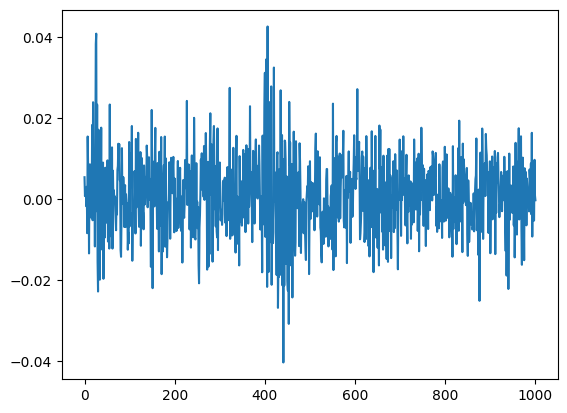

In [12]:
sim_states, sim_returns = jm.SimulationGenerator().run(steps=1000, transition_matrix=transition_matrix, norm_params=norm_params)
plt.plot(sim_returns);

To fit the model, `FeatureGenerator` class enriches the features by adding a family of lagged returns and volatility features. It also standardizes the features.

In [13]:
enriched_returns = jm.FeatureGenerator().enrich_features(sim_returns)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)
enriched_returns.shape

(988, 15)

Finally, the `DiscreteJumpModel` fit the model. `lambda_` determines the penalty for jumps between states. `n_trials` will run the model for given numbers and try different initializations.

09-18 20:30:35 quantbullet.research.jump_model INFO Mean and Volatility by inferred states:
 {0: (0.012255804724548583, 0.8815723205364849), 1: (-0.13019990195608697, 1.8299442418695215)}


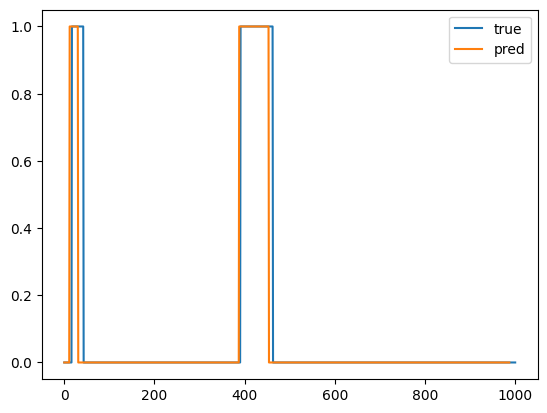

{'BAC': 0.9053542765420775}

In [14]:
model = jm.DiscreteJumpModel()
res = model.fit(enriched_returns, k=2, lambda_=100, rearrange=True, n_trials=4)
model.evaluate(sim_states, res['best_state_sequence'], plot=True)

## Find the best Penalty parameter

In [15]:
from collections import defaultdict
from tqdm import tqdm

bac_lambda_hist = defaultdict(list)
lambda_range = np.logspace(-2, 2, num=5, base=10)
transition_matrix, norm_params = jm.TestingParams().daily()
model = jm.DiscreteJumpModel()

In [16]:
for lambda_ in lambda_range:
    for _ in tqdm(range(20)):
        sim_states, sim_returns = jm.SimulationGenerator().run(steps=1000, transition_matrix=transition_matrix, norm_params=norm_params)
        enriched_returns = jm.FeatureGenerator().enrich_features(sim_returns)
        enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)
        res = model.fit(enriched_returns, k=2, lambda_=lambda_, rearrange=True, n_trials=8)
        score = model.evaluate(sim_states, res['best_state_sequence'], plot=False)
        bac_lambda_hist[str(lambda_)].append(score["BAC"])

  0%|          | 0/20 [00:00<?, ?it/s]09-17 22:21:28 quantbullet.research.jump_model INFO Step 1: Initial (stationary) distribution: [0.84997341 0.15002659]
09-17 22:21:28 quantbullet.research.jump_model INFO Step 2: Simulated states: Counter({0: 988, 1: 13})
09-17 22:21:28 quantbullet.research.jump_model INFO Step 3: Generate simulated return data conditional on states.
09-17 22:23:26 quantbullet.research.jump_model WARNING States identified by volatility ranks and returns ranks are different!
09-17 22:23:26 quantbullet.research.jump_model WARNING States identified by volatility ranks and returns ranks are different!
09-17 22:23:26 quantbullet.research.jump_model WARNING States identified by volatility ranks and returns ranks are different!
09-17 22:23:26 quantbullet.research.jump_model WARNING States identified by volatility ranks and returns ranks are different!
09-17 22:23:26 quantbullet.research.jump_model INFO Mean and Volatility by inferred states:
 {0: (0.36221742508013616, 0.9